# Example: mesh a delineated watershed
    
Here we mesh the East River domain


This uses a range of datasets:

* shapefile from D. Dwivendi/LBNL SFA
* NHD Plus for river network
* NED for elevation, though somewhere is a LIDAR dataset from LBNL that we could use too
* NLCD for land cover/PFT structures
* Either:
    * NRCS soils data, though at the moment this only gets labels, not properties or
    * data from E. Woodburn/LBNL SFA derived from C. Pribulick/Co Mines thesis



In [1]:
%matplotlib inline
figsize = (8,8)  # osx, notebook
#figsize = (16,16) # inline

In [2]:
import sys,os
import numpy as np
from matplotlib import pyplot as plt

import fiona
import rasterio
import shapely.ops

import workflow
import workflow.ui
import workflow.source_list
import workflow.condition
import workflow.colors
import workflow.extrude
import workflow.warp
import workflow.crs


workflow.ui.setup_logging(1,None)

In [3]:
# note that we want to do this work in the DayMet coordinate system, so that our precip can be a true raster/grid
crs = workflow.crs.daymet_crs()

# load the east river shapefile, and convert to our crs
crs_shapefile, east_river_shapes = workflow.get_shapes('../data/domain_boundaries/EastRiver/EastRiver/east_river.shp', crs=crs)

# store it in our preferred data structure
shapes = workflow.split_hucs.SplitHUCs(east_river_shapes)
print("bounds, in DayMet CRS:", shapes.exterior().bounds)

2020-03-27 11:05:54,195 - root - INFO: 
2020-03-27 11:05:54,202 - root - INFO: Preprocessing Shapes
2020-03-27 11:05:54,204 - root - INFO: ------------------------------
2020-03-27 11:05:54,207 - root - INFO: loading file: "../data/domain_boundaries/EastRiver/EastRiver/east_river.shp"


bounds, in DayMet CRS: (-583305.0117196707, -356030.28020474676, -571543.8105054335, -343137.7513377675)


/Users/uec/codes/anaconda/3/envs/ats_meshing_20190719/lib/python3.7/site-packages/fiona/collection.py:336: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)


In [4]:
# collect sources dictionary
sources = workflow.source_list.get_default_sources()
workflow.source_list.log_sources(sources)

2020-03-27 11:05:55,555 - root - INFO: Using sources:
2020-03-27 11:05:55,558 - root - INFO: --------------
2020-03-27 11:05:55,561 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2020-03-27 11:05:55,565 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2020-03-27 11:05:55,566 - root - INFO: DEM: National Elevation Dataset (NED)
2020-03-27 11:05:55,569 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-03-27 11:05:55,571 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-03-27 11:05:55,573 - root - INFO: soil thickness: None
2020-03-27 11:05:55,574 - root - INFO: meteorology: DayMet 1km


2020-03-27 11:05:59,171 - root - INFO: 
2020-03-27 11:05:59,172 - root - INFO: Preprocessing HUC
2020-03-27 11:05:59,172 - root - INFO: ------------------------------
2020-03-27 11:05:59,173 - root - INFO: Loading level 12 HUCs in 1402000102.
2020-03-27 11:05:59,175 - root - INFO: Using HUC file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/WBD_14_GDB/WBD_14.gdb"


(-583305.0117196707, -356030.28020474676, -571543.8105054335, -343137.7513377675)
(-583252.5507942226, -355900.775329357, -571604.4794256322, -343198.1279737944)


2020-03-27 11:06:00,094 - root - INFO:   found 10 HUCs.
2020-03-27 11:06:00,094 - root - INFO:   -- 140200010207
2020-03-27 11:06:00,095 - root - INFO:   -- 140200010203
2020-03-27 11:06:00,096 - root - INFO:   -- 140200010201
2020-03-27 11:06:00,096 - root - INFO:   -- 140200010202
2020-03-27 11:06:00,097 - root - INFO:   -- 140200010204
2020-03-27 11:06:00,098 - root - INFO:   -- 140200010205
2020-03-27 11:06:00,100 - root - INFO:   -- 140200010206
2020-03-27 11:06:00,101 - root - INFO:   -- 140200010208
2020-03-27 11:06:00,102 - root - INFO:   -- 140200010209
2020-03-27 11:06:00,104 - root - INFO:   -- 140200010210


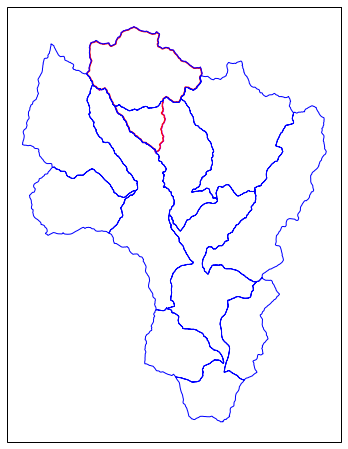

In [5]:
# locate which HUC East River is in
#
# Because the shapefile for East River, as delineated by LBNL, disagrees with the WBD delineation of USGS,
# we had to fiddle a bit to figure out which HUC it was in.  This required finding a 'shrink_factor' that was 
# appropriate to check containment of the shape relative to HUCs. 
shrink_factor = 1.e-2

# This does some plotting of the HUC and the shape to demonstrate the issue.
def figure_out_shrink(shapes, crs, factor):
    fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
    shply = shapes.exterior()
    radius = np.sqrt(shply.area/np.pi)
    shply_s = shply.buffer(-shrink_factor*radius)

    print(shply.bounds)
    print(shply_s.bounds)

    workflow.plot.shply([shapes.exterior(),], crs, 'm', ax)
    workflow.plot.shply([shply_s,], crs, 'r', ax)

    _, huc = workflow.get_hucs(sources['HUC'], '1402000102', 12, crs)
    workflow.plot.shply(huc, crs, 'b', ax)

figure_out_shrink(shapes, crs, shrink_factor)


In [6]:

# if that looks good, we can now find the HUC
hucstr = workflow.find_huc(sources['HUC'], shapes.exterior(), crs, '14', shrink_factor=1.e-2)
print('Found east river in HUC {}'.format(hucstr))

2020-03-27 11:06:05,778 - root - INFO: Using HUC file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/WBD_14_GDB/WBD_14.gdb"
2020-03-27 11:06:06,028 - root - INFO: Using HUC file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/WBD_14_GDB/WBD_14.gdb"
2020-03-27 11:06:06,246 - root - INFO: Using HUC file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/WBD_14_GDB/WBD_14.gdb"
2020-03-27 11:06:06,371 - root - INFO: Using HUC file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/WBD_14_GDB/WBD_14.gdb"
2020-03-27 11:06:06,538 - root - INFO: Using HUC file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/WBD_14_GDB/WBD_14.gdb"
2020-03-27 11:06:06,923 - root - INFO: Using HUC file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/WBD_14_GDB/WBD_14.gdb"


Found east river in HUC 1402000102


In [7]:
# load all rivers in that HUC
_, reaches = workflow.get_reaches(sources['hydrography'], hucstr, shapes.exterior().bounds, crs)
reach_bounds = shapely.ops.cascaded_union([r for r in reaches]).bounds
print('River bounds = {}'.format(reach_bounds))

# simplify the river network
rivers = workflow.simplify_and_prune(shapes, reaches, 
                                     filter=True, simplify=20, prune_reach_size=10)

2020-03-27 11:06:08,227 - root - INFO: 
2020-03-27 11:06:08,229 - root - INFO: Preprocessing Hydrography
2020-03-27 11:06:08,230 - root - INFO: ------------------------------
2020-03-27 11:06:08,231 - root - INFO: Loading streams in HUC 1402000102
2020-03-27 11:06:08,232 - root - INFO:          and/or bounds (-583305.0117196707, -356030.28020474676, -571543.8105054335, -343137.7513377675)
2020-03-27 11:06:08,235 - root - INFO: Using Hydrography file "/Users/uec/research/water/data/watershed-workflow/data-master/hydrography/NHD_H_14020001_GDB/NHD_H_14020001.gdb"
2020-03-27 11:06:08,475 - root - INFO:   found 652 reaches
2020-03-27 11:06:08,716 - root - INFO: 
2020-03-27 11:06:08,716 - root - INFO: Simplifying and pruning
2020-03-27 11:06:08,717 - root - INFO: ------------------------------
2020-03-27 11:06:08,718 - root - INFO: Filtering rivers outside of the HUC space
2020-03-27 11:06:08,720 - root - INFO:   ...filtering


River bounds = (-584974.9422231736, -357892.38571736484, -570520.2717008642, -343381.7279468929)


2020-03-27 11:06:15,218 - root - INFO: Generate the river tree
2020-03-27 11:06:15,256 - root - INFO: Removing rivers with fewer than 10 reaches.
2020-03-27 11:06:15,257 - root - INFO:   ...keeping river with 318 reaches
2020-03-27 11:06:15,258 - root - INFO:   ...removing river with 1 reaches
2020-03-27 11:06:15,259 - root - INFO:   ...removing river with 5 reaches
2020-03-27 11:06:15,261 - root - INFO:   ...removing river with 1 reaches
2020-03-27 11:06:15,262 - root - INFO:   ...removing river with 1 reaches
2020-03-27 11:06:15,264 - root - INFO:   ...removing river with 1 reaches
2020-03-27 11:06:15,267 - root - INFO:   ...removing river with 1 reaches
2020-03-27 11:06:15,268 - root - INFO: simplifying rivers
2020-03-27 11:06:15,322 - root - INFO:   ...cleaned inner segment of length 14.1145 at centroid (-577387.1066350713, -352552.25192735286)
2020-03-27 11:06:15,323 - root - INFO: simplifying HUCs
2020-03-27 11:06:15,345 - root - INFO: snapping rivers and HUCs
2020-03-27 11:06:15

In [13]:
# load the rock creek shapefile, and convert to our crs
crs_shapefile, rock_creek_shapes = workflow.get_shapes('../data/domain_boundaries/EastRiver/RockCreek/rock_creek.shp', 
                                                       crs=crs)

# store it in our preferred data structure
rc = workflow.split_hucs.SplitHUCs(rock_creek_shapes)

2020-03-27 11:11:07,434 - root - INFO: 
2020-03-27 11:11:07,435 - root - INFO: Preprocessing Shapes
2020-03-27 11:11:07,436 - root - INFO: ------------------------------
2020-03-27 11:11:07,437 - root - INFO: loading file: "../data/domain_boundaries/EastRiver/RockCreek/rock_creek.shp"


2020-03-27 11:06:16,141 - root - INFO: 
2020-03-27 11:06:16,143 - root - INFO: Meshing
2020-03-27 11:06:16,149 - root - INFO: ------------------------------
2020-03-27 11:06:16,154 - root - INFO: Triangulating...
2020-03-27 11:06:16,182 - root - INFO:    1195 points and 1194 facets
2020-03-27 11:06:16,183 - root - INFO:  checking graph consistency
2020-03-27 11:06:16,204 - root - INFO:  building graph data structures
2020-03-27 11:06:16,222 - root - INFO:  triangle.build...
2020-03-27 11:06:31,523 - root - INFO:   ...built: 11344 mesh points and 22295 triangles
2020-03-27 11:06:31,524 - root - INFO: Plotting triangulation diagnostics
2020-03-27 11:06:35,708 - root - INFO:   min area = 6.4875030517578125


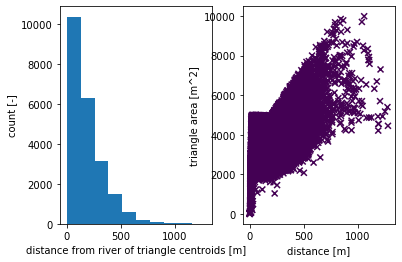

In [8]:
# generate the triangulation

# triangulation options:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, 
# and linearly interpolates between the two endpoints.
d0 = 200; d1 = 800

A0 = 5000; A1 = 10000
#A0 = 1000; A1 = 4000

# make 2D mesh
mesh_points2, mesh_tris, tri_areas = workflow.triangulate(shapes, rivers, diagnostics=True,
                                              refine_distance=[d0,A0,d1,A1])
                                              #refine_min_angle=30)

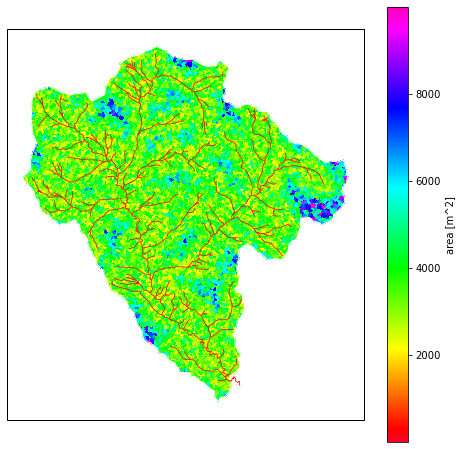

In [9]:
# plot the resulting triangulation, colored by cell area
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
col = workflow.plot.triangulation(mesh_points2, mesh_tris, crs, color=tri_areas, ax=ax, cmap='gist_rainbow')
workflow.plot.hucs(shapes, crs, 'w', ax=ax)
workflow.plot.rivers(rivers, crs, 'r', ax=ax, linewidth=.75)
cb = plt.colorbar(col)
cb.ax.set_ylabel('area [m^2]')
plt.show()

2020-03-27 11:12:10,192 - root - INFO: 
2020-03-27 11:12:10,195 - root - INFO: Preprocessing Raster
2020-03-27 11:12:10,197 - root - INFO: ------------------------------
2020-03-27 11:12:10,201 - root - INFO: collecting raster
2020-03-27 11:12:10,205 - root - INFO: Collecting DEMs to tile bounds: [-107.05902170725882, 38.90472540843425, -106.89762420443195, 39.04397609898299]
2020-03-27 11:12:10,207 - root - INFO:   Need:
2020-03-27 11:12:10,209 - root - INFO:     /Users/uec/research/water/data/watershed-workflow/data-master/dem/USGS_NED_1as_n39_w108.img
2020-03-27 11:12:10,210 - root - INFO:     /Users/uec/research/water/data/watershed-workflow/data-master/dem/USGS_NED_1as_n39_w107.img
2020-03-27 11:12:10,211 - root - INFO:     /Users/uec/research/water/data/watershed-workflow/data-master/dem/USGS_NED_1as_n40_w108.img
2020-03-27 11:12:10,212 - root - INFO:     /Users/uec/research/water/data/watershed-workflow/data-master/dem/USGS_NED_1as_n40_w107.img
2020-03-27 11:12:10,332 - root - I

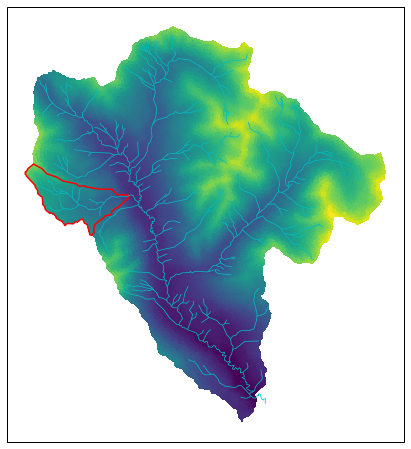

In [15]:
# load a DEM (based currently on NED data) and elevate the triangulation
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], shapes.exterior(), crs)
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)


fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(mesh_points3, mesh_tris, crs, color='elevation', 
                            edgecolors='none', ax=ax)
workflow.plot.rivers(rivers, crs, 'c', ax=ax, linewidth=.75)
workflow.plot.hucs(rc, crs, 'r', ax=ax, linewidth=1.5)

plt.show()

In [ ]:
# construct the 2D surface mesh
m2 = workflow.extrude.Mesh2D(np.copy(mesh_points3), list(mesh_tris))

In [ ]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='k', ax=ax)
ax.set_title('conditioned dz')
plt.show()

In [ ]:
# 
# subsurface structure: get a soil map
soil_fm = workflow.source_list.FileManagerRaster('../data/subsurface_structure/East_River_Data_Sets/commondata/raster_data/soil_grid/w001001.adf')
soil_profile, soil_structure = soil_fm.get_raster(1)

fig = plt.figure()
soil_structure = np.where(soil_structure == 255, 3, soil_structure)
plt.imshow(soil_structure[:,:])

soil_values = workflow.values_from_raster(m2.centroids(), crs, soil_structure + 100, soil_profile)

fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(m2.points, m2.conn, crs, color=soil_values, edgecolors='k', ax=ax, 
                            vmin=100+soil_structure.min(), vmax=100+soil_structure.max())
ax.set_title('soil IDs')
plt.show()

In [ ]:
#
# surface land cover
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], shapes.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
print('Found land cover types: {}'.format(set(lc)))

# plot the NLCD data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

nlcd_inds, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels =  \
    workflow.colors.generate_nlcd_colormap(lc)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, linewidth=0.5, color=lc, 
                                 cmap=nlcd_cmap, norm=nlcd_norm)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels)
plt.savefig('east_river_nlcd')
plt.show()

In [ ]:
# 
# subsurface structure: get a geologic layer map
geo_fm = workflow.source_list.FileManagerRaster('../data/subsurface_structure/East_River_Data_Sets/commondata/raster_data1/large10m_perm/w001001.adf')
geo_profile, geo_structure = geo_fm.get_raster(1)

fig = plt.figure()
geo_structure = np.where(geo_structure == 255, geo_structure[0][0], geo_structure)
plt.imshow(geo_structure[:,:])

geo_values = workflow.values_from_raster(m2.centroids(), crs, geo_structure + 200, geo_profile)

fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(m2.points, m2.conn, crs, color=geo_values, edgecolors='k', ax=ax, 
                            vmin=200+soil_structure.min(), vmax=200+soil_structure.max())
ax.set_title('geo IDs')
plt.savefig('east_river_geo_id')
plt.show()

In [ ]:
# bedrock takes a single id
bedrock_values = 999 * np.ones_like(geo_values)

In [ ]:
#
# Extrude to make the 3D mesh
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z = 0.0

# -- soil layer --
#  top 1 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 9
dz = 0.05
layer_dz = 1.0

def telescope_factor(ncells, dz, layer_dz):
    """Calculates a telescoping factor"""
    if ncells * dz > layer_dz:
        raise ValueError(("Cannot telescope {} cells of thickness at least {} "+
                          "and reach a layer of thickness {}").format(ncells, dz, layer_dz))

    import scipy.optimize
    def seq(r):
        calc_layer_dz = dz * (1 - r**ncells)/(1-r)
        #print('tried: {} got: {}'.format(r, calc_layer_dz))
        return layer_dz - calc_layer_dz
    res = scipy.optimize.root_scalar(seq, x0=1.0001, x1=2)
    return res.root

tele = telescope_factor(ncells, dz, layer_dz)
print("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_values)
    z += dz
    dz *= tele    
#for i in range(ncells-4):
#    layer_types.append('constant')
#    layer_data.append(dz)
#    layer_ncells.append(1)
#    layer_mat_ids.append(geo_values)
#    z += dz
#    dz *= tele
    
# first 1 m geologic layer
dz = 1.0
layer_types.append('constant')
layer_data.append(dz)
layer_ncells.append(1)
layer_mat_ids.append(geo_values)
z += dz

# -- geologic layer --
# keep going for 2m cells until we hit 10 m
dz = 2.0
while (z < 10):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_values)
    z += dz
    
# -- bedrock layer --
# keep going for 2m cells until we hit the bottom of the domain at 30 m
dz = 2.0
while (z < 30):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(bedrock_values)
    z += dz


In [ ]:
workflow.extrude.Mesh3D.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)

In [ ]:
# Extrude to 3D
m3 = workflow.extrude.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [ ]:
# add on land cover side sets
surf_ss = m3.side_sets[1]

for lc_id, lc_label in zip(nlcd_inds, nlcd_labels):
    where = np.where(lc == lc_id)[0]
    ss = workflow.extrude.SideSet(lc_label, int(lc_id), 
                                  [surf_ss.elem_list[w] for w in where],
                                  [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [ ]:
# Write to .exo file for ATS model input
m3.write_exodus('../meshes/mesh_east_river.exo')

In [ ]:
# now generating one without the geologic layer
#
# Extrude to make the 3D mesh
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z = 0.0

# -- soil layer --
#  top 1 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 9
dz = 0.05
layer_dz = 1

tele = telescope_factor(ncells, dz, layer_dz)
print("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_values)
    z += dz
    dz *= tele
    
# first 1 m bedrock layer
dz = 1.0

layer_types.append('constant')
layer_data.append(dz)
layer_ncells.append(1)
layer_mat_ids.append(bedrock_values)
z += dz

# -- geologic layer --
# keep going for 2m cells until we hit 10 m
dz = 2.0
while (z < 10):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(bedrock_values)
    z += dz
    
# -- bedrock layer --
# keep going for 2m cells until we hit the bottom of the domain at 30 m
dz = 2.0
while (z < 30):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(bedrock_values)
    z += dz
    
workflow.extrude.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

In [ ]:
# Extrude to 3D
m3_nogeo = workflow.extrude.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                                   layer_ncells, layer_mat_ids)

In [ ]:
# add on land cover side sets
surf_ss = m3_nogeo.side_sets[1]

for lc_id, lc_label in zip(nlcd_inds, nlcd_labels):
    where = np.where(lc == lc_id)[0]
    ss = workflow.extrude.SideSet(lc_label, int(lc_id), 
                                  [surf_ss.elem_list[w] for w in where],
                                  [surf_ss.side_list[w] for w in where])        
    m3_nogeo.side_sets.append(ss)

In [ ]:
# Write to .exo file for ATS model input
m3_nogeo.write_exodus('../meshes/mesh_east_river_no_geologic.exo')

The below are saved for posterity, and may be useful later!

In [ ]:
# raise error to ensure execution stops here and later stuff isn't executed
raise RuntimeError("stop here")

In [ ]:
# smooth and resample the domain boundary so that it creates a nicer mesh
#

# zooming in on this makes it clear it is derived from a raster -- the shape is stair-stepped
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.hucs(shapes, crs, ax=ax)

# let's try simplifying to a length scale and see how we do
import workflow.split_hucs
workflow.split_hucs.simplify(shapes, 20)

workflow.plot.hucs(shapes, crs, 'b', ax=ax)
plt.show()


In [ ]:
# what does the distribution of edge lengths look like?  This will govern our exterior boundary triangle sizes
line = np.array(shapes.exterior().boundary.xy)
print(line.shape)

dx = np.linalg.norm(line[:,1:] - line[:,:-1], 2, axis=0)

print("Min edge length: {}".format(np.min(dx)))
plt.hist(dx, 40)
plt.show()

